In [1]:
import sys
sys.path.insert(0,'..')

import os
import json
import glob 
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl

from image_processing.utils import show
from image_processing.utils import show
from image_processing.preprocessing import (
    remove_padding,
    pad_to_square
)

# KDE

In [2]:
import random
import scipy.stats as stats
# from statsmodels.nonparametric.kernel_density import KDEMultivariate
from tqdm.notebook import tqdm
from multiprocess import Pool

In [3]:
DATA_DIR = '/Users/kx/Docs/github/git_cccr_sl/chinese-calligraphy-recognition-sl/data/cccr'
N = 16

In [4]:
def get_kernel_contour(kernel, N, step, cmap, norm_const=None):
    
    # get meshgrid and its coordinates
    xx, yy = np.mgrid[0:N:step, 0:N:step]
    positions = np.vstack([xx.ravel(), yy.ravel()])

    # estimation
    f = np.reshape(kernel(positions).T, xx.shape)
    
    if cmap:
        if norm_const is None:
            f = mpl.cm.coolwarm((f - f.min()) / f.max())
        else:
            f = mpl.cm.coolwarm(f / norm_const)
    
    return f
    

## Preprocess data

In [5]:
DATA_DIR = '/Users/kx/Docs/github/git_cccr_sl/chinese-calligraphy-recognition-sl/data/cccr_norm'
chars = [x[-4] + x[-2] for x in glob.glob(DATA_DIR + '/train/*/*/')]

In [6]:
N, M = 32, 32

def read_data(data_dir):
    images = np.zeros((len(glob.glob(data_dir + '/*/*/*.png')), N, M))
    labels = np.zeros(len(images), dtype='int')
    fnames = [None] * len(images)

    i = 0
    for folder in glob.glob(data_dir + '/*/*/'):
        tmp = folder.split('/')
        char = tmp[-3]
        variant = tmp[-2]
        label = np.where(np.array(chars) == (char + variant))[0][0]
        for file in glob.glob(data_dir + '/{}/{}/*.png'.format(char, variant)):
            img = cv2.resize(cv2.imread(file), (M, N))[:, :, 0]
            img = (img > img.max() / 2 - (img.max()/ 100)).astype('int')
            images[i, :, :] = img
            labels[i] = label
            fnames[i] = '/'.join(file.split('/')[-3:])
            i += 1
            
    return images, labels, fnames

imgs_train, y_train, fnames_train = read_data(os.path.join(DATA_DIR, 'train'))
imgs_valid, y_valid, fnames_valid = read_data(os.path.join(DATA_DIR, 'validation'))
imgs_test, y_test, fnames_test = read_data(os.path.join(DATA_DIR, 'test'))

## PDF Estimation

In [8]:
def get_likelihood(kernel, coords):
    return np.log(kernel(coords)).sum()

def get_coords(img):
    return np.argwhere(img).T

In [9]:
bw_method = 'scott'

Xs = [None] * len(chars)
kernels = [None] * len(chars)
for i in tqdm(range(len(chars))):
    imgs = imgs_train[y_train == i]
    Xs[i] = np.concatenate([get_coords(img) for img in imgs], axis=1).T
    kernels[i] = stats.gaussian_kde(Xs[i].T, bw_method=bw_method)

  0%|          | 0/120 [00:00<?, ?it/s]

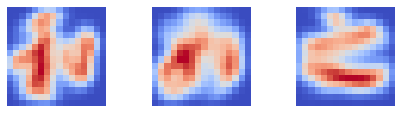

In [10]:
idxs = [3, 4, 49]
contours = [get_kernel_contour(kernels[i], N=N, step=16j, cmap=True) for i in idxs]
show(contours)

## Inference (without optimization)

In [61]:
cache_valid_path = 'pred_cache/validation_{}_{}.npy'.format(bw_method, N)
cache_test_path = 'pred_cache/test_{}_{}.npy'.format(bw_method, N)

In [62]:
imgs_pred = imgs_valid
y_pred_true = y_valid
cache_path = cache_valid_path

In [ ]:
if os.path.isfile(cache_path):
    with open(cache_path, 'rb') as f:
        y_pred = np.load(f)
        counter = np.load(f)
else:
    y_pred = np.zeros((y_pred_true.shape[0], len(chars)))
    counter = 0


for i in tqdm(range(counter, len(imgs_pred))):
    for j in range(len(chars)):
        y_pred[i][j] = get_likelihood(kernels[j], get_coords(imgs_pred[i]))
    if i % 10 == 0:
        with open(cache_path, 'wb') as f:
            np.save(f, y_pred)
            np.save(f, i + 1)

  0%|          | 0/1965 [00:00<?, ?it/s]

In [63]:
with open(cache_path, 'wb') as f:
    np.save(f, y_pred)
    np.save(f, i + 1)

In [114]:
val_positions = {}

for i in range(len(val_preds)):
    char = chars[i]
    preds = val_preds[char]
    val_positions[char] = np.where(np.argsort(-np.array(preds)) == i)[1]


NameError: name 'val_preds' is not defined

In [19]:
def top_k(k):
    a = sum([sum(val_positions[char] < k) for char in val_positions])
    b = sum([len(val_positions[char]) for char in val_positions])
    return round(a / b, 4)

top_k(1), top_k(3)

(0.6827, 0.8353)

# Optimization - Subsampling

Sample half of the data points and fit

## Determining sampling method

In [20]:
val_preds_full = {}
val_preds_a = {}
val_preds_b = {}

for char_id in tqdm(range(len(chars))):
    
    char = chars[char_id]

    preds_full = [[None] * len(chars) for _ in range(len(val[char][:3]))]
    preds_a = [[None] * len(chars) for _ in range(len(val[char][:3]))]
    preds_b = [[None] * len(chars) for _ in range(len(val[char][:3]))]

    for i in (range(len(val[char][:3]))):
        
        coords = np.argwhere(val[char][i]).T  
        
        # sample
        coords_a = coords[:, 0:coords.shape[1]:2]
        coords_b = coords[:, 1:coords.shape[1]:2]

    
        for j in range(len(chars)):
            
            f = kernels[j](coords_a)
            preds_a[i][j] = np.log(f).sum()
            
            f = kernels[j](coords_b)
            preds_b[i][j] = np.log(f).sum()
            
            preds_full[i][j] = preds_a[i][j] + preds_b[i][j]
            
    val_preds_full[char] = preds_full
    val_preds_a[char] = preds_a
    val_preds_b[char] = preds_b

  0%|          | 0/112 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
positions = {}

titles = ['full', 'a', 'b']
for val_preds, title in zip([val_preds_full, val_preds_a, val_preds_b], titles):

    val_positions = {}

    for i in range(len(val_preds)):
        char = chars[i]
        preds = val_preds[char]
        val_positions[char] = np.where(np.argsort(-np.array(preds)) == i)[1]
    
    val_positions_arr = np.array(list(val_positions.values()))
    print("""
        ====== {} ======
        Mean    - {}
        Avg pos - {}\
    """.format(title, (val_positions_arr == 0).mean().round(2), (val_positions_arr).mean().round(2)))
    
    positions[title] = val_positions_arr

In [ ]:
thresh = len(chars) // 3
cond = (positions['a'] >= thresh) | (positions['b'] >= thresh) | (positions['full'] >= thresh)
bad_char_ids, bad_idxs = np.where(cond) 

In [ ]:
bad_imgs = [val[chars[char_id]][bad_id] for (char_id, bad_id) in zip(bad_char_ids, bad_idxs)]
titles = []
for i in range(len(bad_char_ids)):
    char = chars[bad_char_ids[i]]
    pos_a = positions['a'][bad_char_ids, bad_idxs][i]
    pos_b = positions['b'][bad_char_ids, bad_idxs][i]
    pos_full = positions['full'][bad_char_ids, bad_idxs][i]
    titles.append('{}({}/{}/{})'.format(char, pos_a, pos_b, pos_full))
    
    if pos_full < 5 or pos_b < 5 or pos_a < 5:
        titles[-1] += '***'

show(bad_imgs, titles=titles, chinese_title=True)

### EDA
Single sample

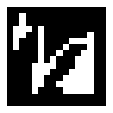

In [168]:
char_id = 30
char = chars[char_id]

preds = [None] * len(chars)

i = 0
show([val[char][i]])

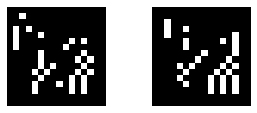

In [84]:
coords = np.argwhere(val[char][i]).T  
coords_a = coords[:, 0:coords.shape[1]:2]
coords_b = coords[:, 1:coords.shape[1]:2]

img_a = np.zeros(shape=val[char][i].shape)
img_b = np.zeros(shape=val[char][i].shape)
img_a[coords_a[0], coords_a[1]] = 1
img_b[coords_b[0], coords_b[1]] = 1
show([img_a, img_b])

In [87]:
for j in range(len(chars)):
    f = kernels[j](coords)
    preds[j] = np.log(f).sum()

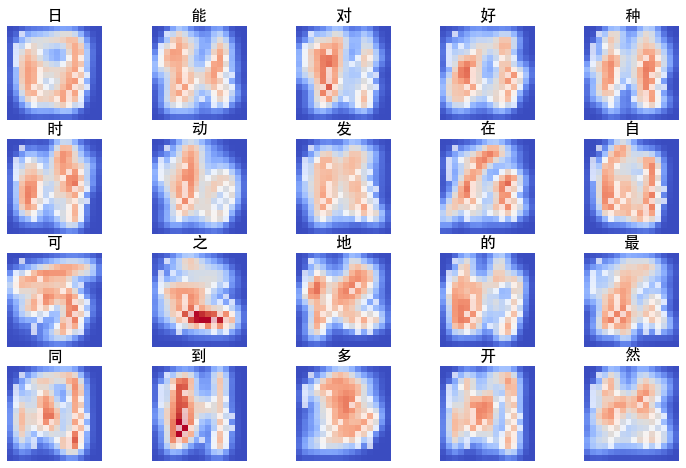

In [88]:
idxs = np.argsort(-np.array(preds))[:50]
contours = [
    get_kernel_contour(kernels[i], N=N, step=16j, cmap=True, norm_const=0.01) for i in idxs[:20]
]
titles = [chars[i] for i in idxs]

for i in range(len(contours)):
    contours[i][:,:,3] = 1 - img_a * 0.7
    
show(contours, titles=titles, chinese_title=True, col=5)

## Top-1 acc

In [113]:
accs = [None] * len(chars)
for char_id in range(len(chars)):
    char_id = 0
    preds = val_preds[chars[char_id]]
    accs[char_id] = (np.argmax(preds, axis=1) == char_id).sum() / 20
    
accs = np.array(accs)
accs.mean()

In [ ]:
plt.hist(accs, [i/10 for i in range(10)])
plt.xlabel('top-1 acc')
plt.ylabel('freq')

## ...

In [ ]:
np.argwhere(accs < 0.5)[:, 0]

0 - 后 - pdf too similar to 这, variants
4 - 如 - too unconstrained
7 - 最 - variants, image too small?
10 - 国 - pdf too similar to 用同
13 - 看 - image too small???
19 - 就 - ???
21 - 发 - variants
31 - 从 - ???


? - variants 么

In [ ]:
char_id = 37
char = chars[char_id]

print(accs[char_id])

preds = test_preds[chars[char_id]]

preds = np.array(preds)
preds_sorted = np.argsort(-preds, axis=1)
preds_rank = np.argwhere(preds_sorted == char_id)[:, 1]

titles = []
for i in range(len(test[char])):
    titles.append(','.join([chars[preds_sorted[i, j]] for j in range(3)]))
    titles[-1] += str(preds[i, preds_sorted[i, 0]].round())
    
show(test[char], titles=titles, chinese_title=True)
# show(train[char])

In [ ]:
f = fs[char_to_id['也']]

fig = plt.figure(figsize=(3,3))
ax = fig.gca()
ax.set_xlim(0, N)
ax.set_ylim(0, N)
# ax.contourf(xx, yy, f, cmap='coolwarm')
# ax.contour(xx, yy, f, colors='black')
ax.imshow(np.rot90(f), cmap='coolwarm', extent=[0, N, 0, N])
ax.axis("off")

In [ ]:
# multiprocessing kde

# n_cores = 2
# char = '起'

# with Pool(n_cores) as pool:

#     preds = [[None] * len(chars) for _ in range(len(test[char]))]

#     for i in tqdm(range(len(test[char]))):
#         for j in range(len(chars)):
#             coords = np.argwhere(test[char][i]).T            
#             tasks = [(x, kernels[j]) for x in np.array_split(coords, n_cores, axis=1)]
#             results = pool.map(lambda x: x[1](x[0]), tasks)
#             preds[i][j] = sum([np.log(x).sum() for x in results])
        